## iForest, CNN and Ensemble reliable sites analysis and Illumina ground-truth comparison

In [1]:
# import basic modules
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import pysam
from tqdm import tqdm

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

from C_to_U_classifier_plus_min.utils import create_sequence_logo, get_rev_compl


def produce_consensus(df, title, interval, ref_filepath):
    with tqdm(total=df.shape[0]) as pbar:
        refs = []
        ref = pysam.FastaFile(ref_filepath)
        for site in df.itertuples():
            region = site[1]
            pos1based = site[2]
            pos0based = pos1based-1
            strand = site[3]
            reference = ref.fetch(region, pos0based-interval, pos0based+interval+1)
            if strand == "+":
                refs.append(list(reference))
            elif strand == "-":
                reference = get_rev_compl(reference)
                refs.append(list(reference))
            pbar.update(1)
    ref.close()
    
    refs = pd.DataFrame(refs, columns=[f"{i}" for i in range(interval*2+1)])
    refs_freqs = {}
    for rel_pos in refs:
        refs_freqs[int(rel_pos)] = refs[rel_pos].value_counts().sort_index()
    refs = pd.DataFrame(refs_freqs).fillna(0)
    depths = refs.sum().tolist()
    refs = refs / depths
    refs = refs.T

    create_sequence_logo(refs, title=f"{title}")

In [2]:
# define some inputs filepath
wt_bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/wt.bam"
ko_bam_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/ko.bam"
ref_filepath = "/lustre/bio_running/C_to_U_editing/refs/GRCm39.genome.fa"

In [3]:
# load iForest model detected reliable sites
iforest = pd.read_table("/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/reliable_ed_sites_iForest_SNP_m5C_WT_noKO.apobec1.tsv", index_col=0)
iforest

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4915426,+,2,2,51,0.039216,0.039216,TGCAT,1,0.001079
1,chr1,4915443,+,5,3,54,0.092593,0.055556,TACAA,1,0.000049
2,chr1,4915467,+,5,4,55,0.090909,0.072727,TACAG,1,0.005247
3,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521
4,chr1,4915760,+,2,2,58,0.034483,0.034483,GTCAA,1,0.009496
...,...,...,...,...,...,...,...,...,...,...,...
1065,chrX,153996199,-,2,2,71,0.028169,0.028169,TACAC,1,0.000192
1066,chrX,153996364,-,10,2,72,0.138889,0.027778,GACGT,1,0.004047
1067,chrX,154115400,-,9,4,125,0.072000,0.032000,TACTG,1,0.000807
1068,chrX,158165691,+,6,4,125,0.048000,0.032000,ATCAA,1,0.000734


In [4]:
# load CNN wavenet model detected reliable sites
cnn = pd.read_table("/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr//wt_ko/wt_ko.CNN_wavenet_08/reliable_ed_sites_CNNwavenet_SNP_m5C_WT_noKO.apobec1.tsv", index_col=0)
cnn

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat,p_value
0,chr1,4915457,+,4,2,51,0.078431,0.039216,TACTA,1,4.720720e-05
1,chr1,4915694,+,7,2,51,0.137255,0.039216,TACTA,1,5.212852e-04
2,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,9.861242e-05
3,chr1,4916432,+,3,1,69,0.043478,0.014493,AACAT,1,4.565154e-07
4,chr1,4916454,+,6,3,60,0.100000,0.050000,ATCTT,1,8.767610e-05
...,...,...,...,...,...,...,...,...,...,...,...
941,chrX,135147776,+,15,9,56,0.267857,0.160714,AACTT,1,2.345928e-05
942,chrX,135633733,-,12,3,122,0.098361,0.024590,ATCTT,1,9.604205e-06
943,chrX,135633941,-,16,2,156,0.102564,0.012821,GACGT,1,2.943394e-03
944,chrX,141022655,+,3,1,52,0.057692,0.019231,AACTT,1,1.256081e-05


In [5]:
# retrieve ensemble reliable editing sites that were called by both iForest and CNN wavenet models.
reliable_ed_pos_ensemble = pd.read_table("reliable_ed_pos_ensembl.apobec1.tsv")
reliable_ed_pos_ensemble

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
0,chr1,4915694,+,7,4,51,0.137255,0.078431,TACTA,1,0.000521,7,2,51,0.137255,0.039216,TACTA,1,0.000521
1,chr1,4916406,+,3,3,67,0.044776,0.044776,GACTT,1,0.000099,3,3,67,0.044776,0.044776,GACTT,1,0.000099
2,chr1,4967180,+,7,3,108,0.064815,0.027778,TACTC,1,0.000004,5,2,108,0.046296,0.018519,TACTC,1,0.000004
3,chr1,4967189,+,11,4,114,0.096491,0.035088,AACGG,1,0.000003,9,4,114,0.078947,0.035088,AACGG,1,0.000003
4,chr1,4967193,+,6,3,112,0.053571,0.026786,GACTT,1,0.000011,5,2,112,0.044643,0.017857,GACTT,1,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,chrX,108206054,+,2,2,96,0.020833,0.020833,TTCAA,1,0.000939,2,1,96,0.020833,0.010417,TTCAA,1,0.000939
339,chrX,135147776,+,15,12,56,0.267857,0.214286,AACTT,1,0.000023,15,9,56,0.267857,0.160714,AACTT,1,0.000023
340,chrX,135147837,+,11,7,52,0.211538,0.134615,AACAC,1,0.001189,11,3,52,0.211538,0.057692,AACAC,1,0.001189
341,chrX,153996147,-,8,3,62,0.129032,0.048387,TACTC,1,0.000004,8,1,62,0.129032,0.016129,TACTC,1,0.000004


In [6]:
# evaluate well known edited position chr2:121983221
reliable_ed_pos_ensemble.query("region == 'chr2'").query("position == 121983221")

,region,position,strand,T_native_x,T_corrected_x,depth_stranded_x,Tfreq_native_x,Tfreq_corrected_x,5mer_x,y_hat_x,p_value_x,T_native_y,T_corrected_y,depth_stranded_y,Tfreq_native_y,Tfreq_corrected_y,5mer_y,y_hat_y,p_value_y
172,chr2,121983221,+,280,166,851,0.329025,0.195065,TACAC,1,0.004419,254,9,851,0.298472,0.010576,TACAC,1,0.004419


In [7]:
# let's compare ground truth illumina sites
ed_pos_filepath = "/lustre/bio_running/C_to_U_editing/merged_mm39.tsv"
ed_pos_columns_filepath = "/lustre/bio_running/C_to_U_editing/merged_mm39_columns.txt"
# open wt, ko and illumina ground truth table
with open(ed_pos_columns_filepath) as columns:
    ed_pos = pd.read_table(ed_pos_filepath, header=None)
    ed_pos.columns = [i.rstrip() for i in columns.readlines()]
ed_pos

,contig_mm39,pos_mm39,contig_mm10,pos_mm10,ref_base,strand,cov_WT,MeanQual_WT,"BaseCount_WT[A,C,G,T]",Subs_WT,SubsFreq_WT,cov_KO,MeanQual_KO,"BaseCount_KO[A,C,G,T]",Subs_KO,SubsFreq_KO,PositionAnnotation,gene_name
0,chr1,4915683,chr1,4845460,C,1,290,35.40,"[0, 258, 0, 32]",CT,0.11,184,35.08,"[0, 184, 0, 0]",-,0.0,UTR3,Lypla1
1,chr1,4915694,chr1,4845471,C,1,290,35.45,"[0, 258, 0, 32]",CT,0.11,183,35.54,"[0, 183, 0, 0]",-,0.0,UTR3,Lypla1
2,chr1,4915851,chr1,4845628,C,1,142,35.19,"[0, 135, 0, 7]",CT,0.05,83,35.00,"[0, 83, 0, 0]",-,0.0,UTR3,Lypla1
3,chr1,4916384,chr1,4846161,C,1,183,35.79,"[0, 164, 0, 19]",CT,0.10,134,35.85,"[0, 134, 0, 0]",-,0.0,UTR3,Lypla1
4,chr1,4967044,chr1,4896821,C,1,439,35.51,"[0, 404, 0, 35]",CT,0.08,325,35.56,"[0, 325, 0, 0]",-,0.0,UTR3,Tcea1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,chrX,166129481,chrX,167346485,C,0,125,35.35,"[0, 119, 0, 6]",CT,0.05,86,35.72,"[0, 86, 0, 0]",-,0.0,UTR3,Prps2
683,chrX,166130959,chrX,167347963,C,0,70,35.71,"[0, 66, 0, 4]",CT,0.06,70,35.58,"[0, 70, 0, 0]",-,0.0,UTR3,Prps2
684,chrX,166131073,chrX,167348077,C,0,116,35.45,"[0, 110, 0, 6]",CT,0.05,128,35.77,"[0, 128, 0, 0]",-,0.0,UTR3,Prps2
685,chrX,166131296,chrX,167348300,C,0,133,35.46,"[0, 120, 0, 13]",CT,0.10,102,35.44,"[0, 102, 0, 0]",-,0.0,UTR3,Prps2


Probably several illumina ground-truth sites were not retrieved because of low coverage due to ONT direct-RNA setup.

In [8]:
# focus only on Illumina ground-truth sites that are well covered (depth > 50) on both WT and KO samples of ONT runs

wt_bam_file = pysam.AlignmentFile(wt_bam_filepath)
ko_bam_file = pysam.AlignmentFile(ko_bam_filepath)

ref = pysam.FastaFile(ref_filepath)

illumina_set = set() # well covered on WT sample
with tqdm(total=ed_pos.shape[0]) as pbar:
    for s in ed_pos.itertuples():
        site = f"{s[1]}:{s[2]}"
        
        # retrive depth for current illumina site from WT ONT run
        for pileupcolumn in wt_bam_file.pileup(site.split(":")[0],
                                            int(site.split(":")[1])-1,
                                            int(site.split(":")[1]), 
                                            truncate=True, 
                                            max_depth=1000000, 
                                            min_base_quality=0):

                    column = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
                    depth_wt = 0
                    for i in [i[0].upper() for i in column]:
                        if i.isupper():
                            depth_wt += 1

        # retrive depth for current illumina site from KO ONT run
        for pileupcolumn in ko_bam_file.pileup(site.split(":")[0],
                                            int(site.split(":")[1])-1,
                                            int(site.split(":")[1]), 
                                            truncate=True, 
                                            max_depth=1000000, 
                                            min_base_quality=0):

                    column = pileupcolumn.get_query_sequences(mark_matches=True, add_indels=True)
                    depth_ko = 0
                    for i in [i[0].upper() for i in column]:
                        if i.isupper():
                            depth_ko += 1
                    
                    
        if (depth_wt > 50) and (depth_ko > 50):
            illumina_set.add(site)
            
        pbar.update(1)

# close input files and print total counter of reliable sites retrieved
wt_bam_file.close()
ko_bam_file.close() 
ref.close()

100%|██████████| 687/687 [00:34<00:00, 19.92it/s]


In [9]:
illumina_set

{'chr10:57391969',
 'chr10:57392081',
 'chr10:60934632',
 'chr11:20012532',
 'chr11:20012745',
 'chr11:20175333',
 'chr11:29692507',
 'chr11:29692828',
 'chr11:29692881',
 'chr11:46619454',
 'chr11:49995507',
 'chr11:52137422',
 'chr11:75517093',
 'chr12:31646149',
 'chr12:33026227',
 'chr12:33026255',
 'chr12:33026295',
 'chr12:54692685',
 'chr12:54692931',
 'chr12:54692963',
 'chr12:85389705',
 'chr13:38684812',
 'chr13:47239196',
 'chr13:47239246',
 'chr13:47239251',
 'chr13:47239273',
 'chr13:58273742',
 'chr13:64511709',
 'chr13:74451771',
 'chr14:122396392',
 'chr14:13670266',
 'chr14:21498370',
 'chr14:26377387',
 'chr14:29696720',
 'chr14:36843018',
 'chr14:63382117',
 'chr15:25363655',
 'chr15:36772847',
 'chr15:36999716',
 'chr15:38692148',
 'chr15:4183575',
 'chr15:4183624',
 'chr15:4183636',
 'chr15:4183736',
 'chr15:43141776',
 'chr15:59202978',
 'chr15:99306501',
 'chr16:32450852',
 'chr16:43907686',
 'chr17:71281181',
 'chr17:74507910',
 'chr17:74507943',
 'chr18:3593930

In [10]:
len(illumina_set)

233

In [11]:
# evaluate how many sites of those among illumina ground truth have been retrieved in the reliable sites of ensemble table
# produce sets
iforest_set = set()
for site in iforest.itertuples():
    iforest_set.add(f"{site[1]}:{site[2]}")

cnn_set = set()
for site in cnn.itertuples():
    cnn_set.add(f"{site[1]}:{site[2]}")

ensemble_set = set()
for site in reliable_ed_pos_ensemble.itertuples():
    ensemble_set.add(f"{site[1]}:{site[2]}")

In [12]:
# produce intersections
iforest_x_illumina_set = iforest_set.intersection(illumina_set)
cnn_x_illumina_set = cnn_set.intersection(illumina_set)
ensemble_x_illumina_set = ensemble_set.intersection(illumina_set)

print("Total ground-truth illumina site:", ed_pos.shape[0])
print("Total ground-truth illumna sites well coverend in both WT and KO ONT runs:", len(illumina_set))
print("iForest reliable sites intersected with illumina ground-truth:", len(iforest_x_illumina_set))
print("CNN wavenet reliable sites intersected with illumina ground-truth:", len(cnn_x_illumina_set))
print("Ensemble (iForest_x_cnn) reliable sites intersected with illumina ground-truth:", len(ensemble_x_illumina_set))

Total ground-truth illumina site: 687
Total ground-truth illumna sites well coverend in both WT and KO ONT runs: 233
iForest reliable sites intersected with illumina ground-truth: 124
CNN wavenet reliable sites intersected with illumina ground-truth: 44
Ensemble (iForest_x_cnn) reliable sites intersected with illumina ground-truth: 46


## Consensus for Reliable sites among those falling on illumina groud truth covered sites

In [13]:
iforest_x_illumina = pd.merge(iforest, pd.DataFrame([[i.split(":")[0], int(i.split(":")[1])] for i in iforest_x_illumina_set], columns=["region", "position"]), how="inner", on=["region", "position"])
cnn_x_illumina = pd.merge(cnn, pd.DataFrame([[i.split(":")[0], int(i.split(":")[1])] for i in cnn_x_illumina_set], columns=["region", "position"]), how="inner", on=["region", "position"])
ensemble_x_illumina = pd.merge(reliable_ed_pos_ensemble, pd.DataFrame([[i.split(":")[0], int(i.split(":")[1])] for i in ensemble_x_illumina_set], columns=["region", "position"]), how="inner", on=["region", "position"])

100%|██████████| 124/124 [00:01<00:00, 91.36it/s]
findfont: Font family ['Arial Rounded MT Bold'] not found. Falling back to DejaVu Sans.


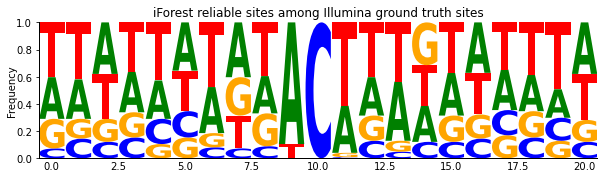

In [14]:
produce_consensus(iforest_x_illumina, "iForest reliable sites among Illumina ground truth sites", 10, ref_filepath)

100%|██████████| 44/44 [00:00<00:00, 833.44it/s]


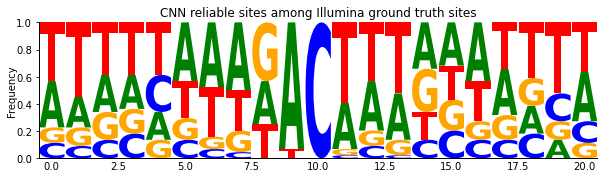

In [15]:
produce_consensus(cnn_x_illumina, "CNN reliable sites among Illumina ground truth sites", 10, ref_filepath)

100%|██████████| 46/46 [00:00<00:00, 20085.15it/s]


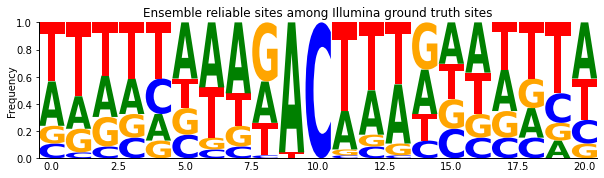

In [16]:
produce_consensus(ensemble_x_illumina, "Ensemble reliable sites among Illumina ground truth sites", 10, ref_filepath)